# Stock Price Forecast using LSTM

# Import libraries

In [56]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.utils.data
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.stattools import adfuller

# Set variables

In [57]:
# Set variables
ticker = 'DIS'
start_date = '2018-04-02'
end_date = '2023-04-02'
interval = '1d'
data_col = 'Close'

# Import data

In [58]:
# Download stock price from Yahoo Finance
stock_price = yf.download(ticker, start=start_date, end=end_date, interval=interval)[data_col]
stock_price = pd.DataFrame(stock_price)
stock_price_raw = stock_price
stock_price.head()

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2018-04-02,98.660004
2018-04-03,99.419998
2018-04-04,100.949997
2018-04-05,102.110001
2018-04-06,100.349998


# Stock data analysis

## Check missing value

In [59]:
# Check null
stock_price.isnull().sum()

Close    0
dtype: int64

Stock price has no missing values

## Plot stock price

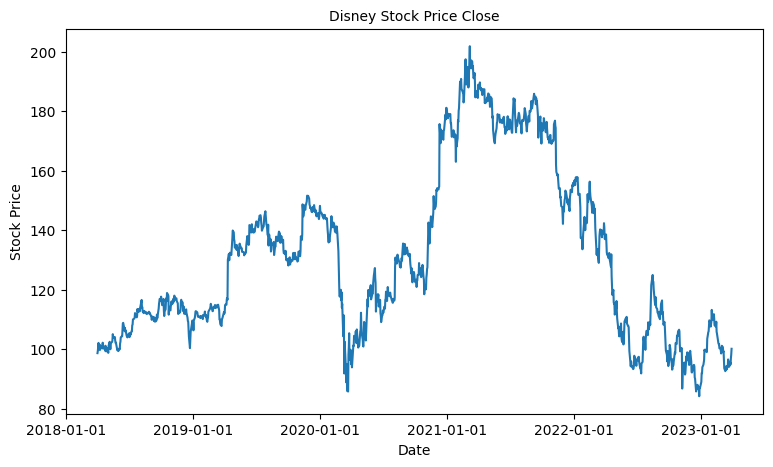

In [60]:
# Create the plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(stock_price.index, stock_price.values)

# Format the x-axis ticks to show the full date
date_fmt = '%Y-%m-%d'
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter(date_fmt))

# Set labels and title
ax.set_xlabel('Date', size=10)
ax.set_ylabel('Stock Price', size=10)
ax.set_title('Disney Stock Price Close', size=10)

# Display the plot
plt.show()

The raw data in the stock price close data exhibits a certain pattern. Despite a decrease at the beginning of Q1 2020, there is a general upward trend and again downward trend from the middle of 2021 

## Trend, Seasonal & Residual

In [61]:
# Decomposition
decomposition = sm.tsa.seasonal_decompose(stock_price, model='additive', period=150)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

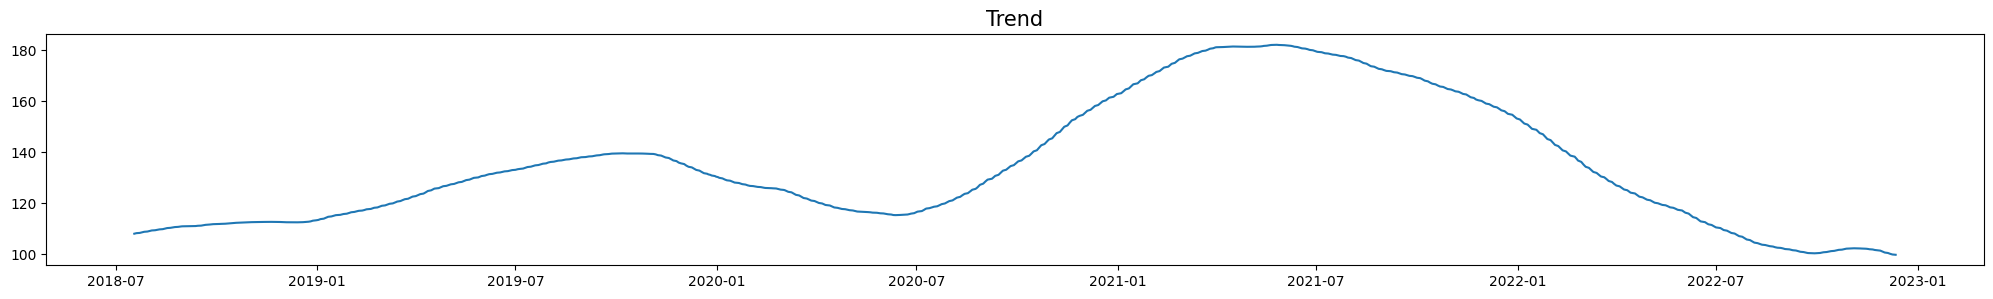

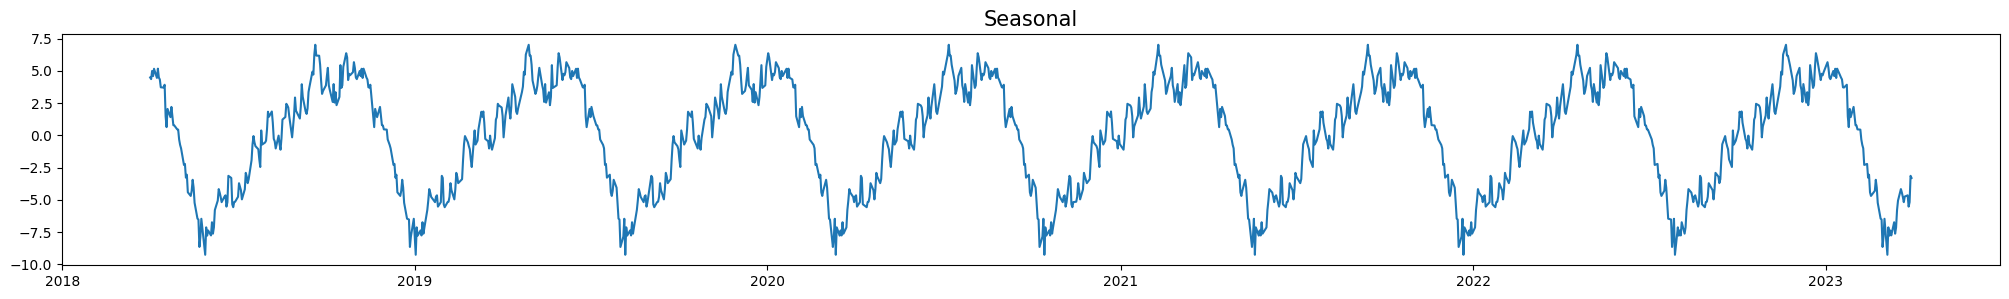

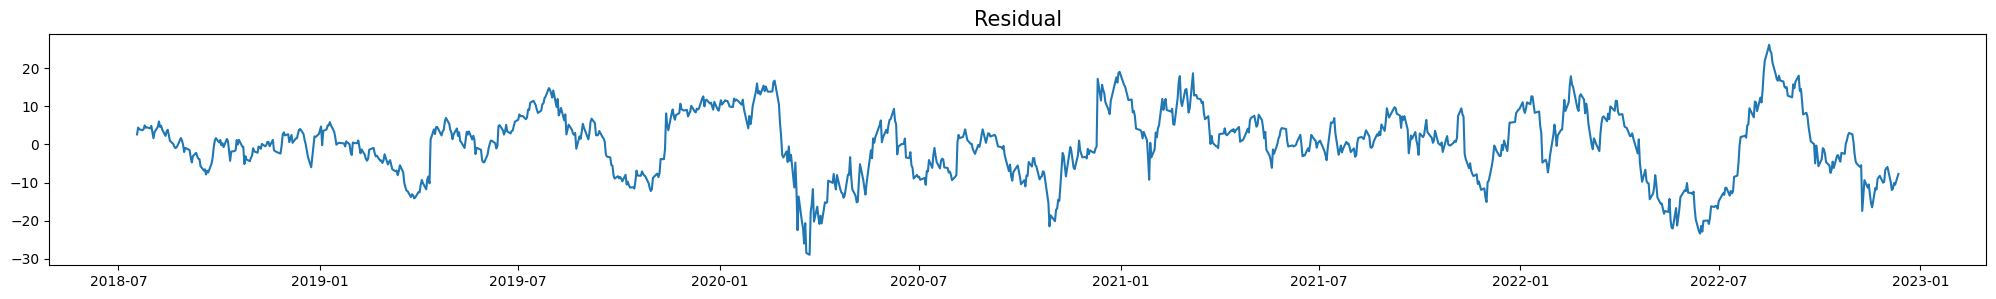

In [62]:
# Plot trend
fig, axt = plt.subplots(figsize=(25, 3))
axt.plot(trend)
axt.set_title('Trend', size=15)
plt.show()

# Plot seasonality
fig, axs = plt.subplots(figsize=(25, 3))
axs.plot(seasonal)
axs.set_title('Seasonal', size=15)
plt.show()

# Plot residual
fig, axr = plt.subplots(figsize=(25, 3))
axr.plot(residual)
axr.set_title('Residual', size=15)
plt.show()

**Trend of stock close data:** 

It represents the long-term movement of the series, such as whether it is increasing, decreasing or remaining stable over time. The trend can be linear or nonlinear and can be described as either a function of time or as a simple average of the series over a specific time period. Analyzing the trend in time series data is useful in identifying patterns and forecasting future behavior of the data. Trends can be modeled and removed from the time series data to reveal other important features such as seasonality and irregularities.

**Seasonality of stock close data:**

The seasonality of stock price time series data refers to the repeating patterns or cycles that occur at fixed intervals, such as daily, weekly, or monthly, over a given period. These patterns can be caused by various factors, such as economic cycles, seasonal events, and company-specific factors, and can have a significant impact on the stock prices.

**Residuals**:

After the trend and seasonal components have been removed from the time series, the residual is calculated. If the resulting residual is relatively consistent, it suggests that the time series has a stationary structure and is suitable for modeling purposes.

## Scale stock price

In [63]:
# Normalize the data
sc = MinMaxScaler(feature_range=(-1, 1))
stock_price['Close'] = sc.fit_transform(stock_price['Close'].values.reshape(-1, 1))
stock_price_scaled = stock_price
stock_price.head()

,Close
Date,
2018-04-02,-0.753864
2018-04-03,-0.740955
2018-04-04,-0.714965
2018-04-05,-0.695261
2018-04-06,-0.725157


## Check outliers

In [64]:
outliers_fraction = 0.01

# IsolationForest model
if_clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=outliers_fraction, random_state=42)
if_clf.fit(stock_price)

# Predict the labels of the data (1 for inliers, -1 for outliers)
stock_price['Anomaly'] = if_clf.predict(stock_price)
stock_price[stock_price['Anomaly'] == -1]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,Close,Anomaly
Date,,
2020-03-20,-0.969254,-1
2020-03-23,-0.972991,-1
2021-02-23,0.918125,-1
2021-02-24,0.925259,-1
2021-03-08,1.000000,-1
2021-03-11,0.912349,-1
2021-03-12,0.919314,-1
2021-03-15,0.912519,-1
2021-03-17,0.886700,-1


In [65]:
stock_price.drop(columns=['Anomaly'], inplace=True)

## Check stationarity

There are three basic criterion for a time series to understand whether it is stationary series or not.


Statistical properties of time series such as mean, variance should remain constant over time to call time series is stationary
- constant mean
- constant variance
- autocovariance that does not depend on time. autocovariance is covariance between time series and lagged time series.

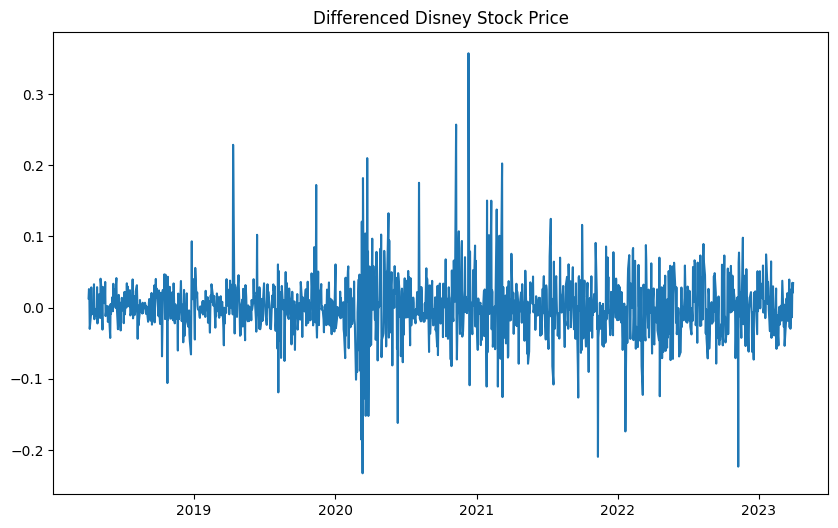

In [66]:
stock_price_diff = stock_price.diff().dropna()

plt.figure(figsize=(10,6))
plt.plot(stock_price_diff)
plt.title('Differenced Disney Stock Price')
plt.show()

In [67]:
# Raw stock
stat_sp = adfuller(stock_price)
print(f'The test statistics is {stat_sp[0]} and p-value is {stat_sp[1]}')

# Stock after differencing
stat_sp_diff = adfuller(stock_price_diff)
print(f'After differencing the test statistics is {stat_sp_diff[0]} and p-value is {stat_sp_diff[1]}')

The test statistics is -1.6929348514509868 and p-value is 0.43475628113545306
After differencing the test statistics is -11.295344234301101 and p-value is 1.3480231530096826e-20


# Split Train/Test data

In [68]:
# Train/Test split
split_ratio = 0.8
split_pos = int(split_ratio*len(stock_price))

train_set = stock_price.iloc[:split_pos].values
test_set = stock_price.iloc[split_pos:].values

# Prepare Test/Train dataset

## Custom dataset class

In [69]:
# Custom dataset
class Stock_Dataset(Dataset):
  def __init__(self, data, seq_len):
    self.data = data
    self.seq_len = seq_len

  def __len__(self):
    return len(self.data) - self.seq_len -1

  def __getitem__(self, index):
    # Create sequence for LSTM model
    x_seq = self.data[index:index+self.seq_len]
    y_seq = self.data[index+self.seq_len]
    # Return tensors
    return torch.tensor(x_seq).float(), torch.tensor(y_seq).float()

## Test/Train dataset & data loader

In [70]:
seq_len = 16
batch_size = 16

# Create train/test dataset
train_dataset = Stock_Dataset(train_set, seq_len)
test_dataset = Stock_Dataset(test_set, seq_len)

# Create train/test data loader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Build LSTM model

## Design LSTM model

In [71]:
class LSTM_Forecast(nn.Module):
  def __init__(self, input_size=1, hidden_size=30, output_size=1, lstm_layers=1):
    super(LSTM_Forecast, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.lstm_layers = lstm_layers

    # Create LSTM layer
    self.lstm = nn.LSTM(input_size, hidden_size, lstm_layers)
    # Create fully connected layer
    self.linear = nn.Linear(hidden_size, output_size)
      
  def forward(self, input):
    # Define states
    h_st = torch.zeros(self.lstm_layers, input.size(1), self.hidden_size)         # LSTM hidden state
    c_st = torch.zeros(self.lstm_layers, input.size(1), self.hidden_size)         # LSTM cell state
    
    # Outputs
    out, (hn, cn) = self.lstm(input, (h_st, c_st))
    out = self.linear(out[-1])
    
    return out

## Model summary

In [72]:
# Initialize model
model = LSTM_Forecast()
model

LSTM_Forecast(
  (lstm): LSTM(1, 30)
  (linear): Linear(in_features=30, out_features=1, bias=True)
)

# Train model

## Define hyperparameters

In [73]:
# Check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Hyperparameters
learning_rate = 5e-5
epochs = 100
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

## Training statistics

In [74]:
pbar = tqdm(range(epochs))

# Train/validation losses
train_total_loss = []
test_total_loss = []

# Train and evaluate model
for epoch in pbar:
  train_loss = 0
  test_loss = 0

  # Set the model to training state
  model.train()                                                                                                             

  # Train the model on the train dataset
  for i, (inputs, targets) in enumerate(train_dataloader):
    optimizer.zero_grad()

    inputs = inputs.to(device)
    targets = targets.squeeze().to(device)

    # Forward pass
    tr_outputs = model(inputs).squeeze()
    tr_loss = criterion(tr_outputs, targets)
    train_loss += tr_loss.item()
    tr_loss.backward()
    optimizer.step()

  # Calculate total training loss
  tr_epoch_loss = train_loss/len(train_dataloader)
  train_total_loss.append(tr_epoch_loss)

  # Set the model to evaluation mode
  model.eval()

  # Evaluate the model on the test dataset
  for i, (inputs, targets) in enumerate(test_dataloader):
    with torch.no_grad():
      inputs = inputs.to(device)
      targets = targets.squeeze().to(device)

      te_outputs = model(inputs).squeeze()
      te_loss = criterion(te_outputs, targets)
    
    test_loss += te_loss.item()
        
  # Calculate total test loss
  te_epoch_loss = test_loss/len(test_dataloader)
  test_total_loss.append(te_epoch_loss)

  # Print stats at each epoch
  if(epoch%1 == 0):
    pbar.set_description(f"Epoch {epoch+1}/{epochs} \t")
    print(f'Train Loss: {tr_loss.item():.4f}, Test Loss: {te_loss.item():.4f}')

Epoch 1/100 	:   1%|          | 1/100 [00:00<00:49,  2.02it/s]

Train Loss: 0.2002, Test Loss: 0.2583


Epoch 2/100 	:   2%|▏         | 2/100 [00:00<00:48,  2.00it/s]

Train Loss: 0.1677, Test Loss: 0.3818


Epoch 3/100 	:   3%|▎         | 3/100 [00:01<00:55,  1.74it/s]

Train Loss: 0.2264, Test Loss: 0.3581


Epoch 4/100 	:   4%|▍         | 4/100 [00:02<00:59,  1.62it/s]

Train Loss: 0.1799, Test Loss: 0.3051


Epoch 5/100 	:   5%|▌         | 5/100 [00:03<01:02,  1.52it/s]

Train Loss: 0.1623, Test Loss: 0.3971


Epoch 6/100 	:   6%|▌         | 6/100 [00:03<01:04,  1.45it/s]

Train Loss: 0.1519, Test Loss: 0.3401


Epoch 7/100 	:   7%|▋         | 7/100 [00:04<01:04,  1.45it/s]

Train Loss: 0.2700, Test Loss: 0.3134


Epoch 8/100 	:   8%|▊         | 8/100 [00:05<01:04,  1.43it/s]

Train Loss: 0.2284, Test Loss: 0.3352


Epoch 9/100 	:   9%|▉         | 9/100 [00:05<00:59,  1.54it/s]

Train Loss: 0.1687, Test Loss: 0.3454


Epoch 10/100 	:  10%|█         | 10/100 [00:06<00:53,  1.69it/s]

Train Loss: 0.1757, Test Loss: 0.3398


Epoch 11/100 	:  11%|█         | 11/100 [00:06<00:49,  1.81it/s]

Train Loss: 0.1409, Test Loss: 0.3634


Epoch 12/100 	:  12%|█▏        | 12/100 [00:07<00:47,  1.87it/s]

Train Loss: 0.2291, Test Loss: 0.2838


Epoch 13/100 	:  13%|█▎        | 13/100 [00:07<00:45,  1.93it/s]

Train Loss: 0.1821, Test Loss: 0.3614


Epoch 14/100 	:  14%|█▍        | 14/100 [00:08<00:44,  1.95it/s]

Train Loss: 0.1395, Test Loss: 0.3807


Epoch 15/100 	:  15%|█▌        | 15/100 [00:08<00:43,  1.97it/s]

Train Loss: 0.1561, Test Loss: 0.3545


Epoch 16/100 	:  16%|█▌        | 16/100 [00:09<00:43,  1.94it/s]

Train Loss: 0.1700, Test Loss: 0.2618


Epoch 17/100 	:  17%|█▋        | 17/100 [00:09<00:43,  1.92it/s]

Train Loss: 0.2752, Test Loss: 0.3387


Epoch 18/100 	:  18%|█▊        | 18/100 [00:10<00:41,  2.00it/s]

Train Loss: 0.2112, Test Loss: 0.3297


Epoch 19/100 	:  19%|█▉        | 19/100 [00:10<00:39,  2.04it/s]

Train Loss: 0.1491, Test Loss: 0.2624


Epoch 20/100 	:  20%|██        | 20/100 [00:11<00:39,  2.02it/s]

Train Loss: 0.3103, Test Loss: 0.2657


Epoch 21/100 	:  21%|██        | 21/100 [00:11<00:39,  2.02it/s]

Train Loss: 0.2671, Test Loss: 0.2850


Epoch 22/100 	:  22%|██▏       | 22/100 [00:12<00:37,  2.07it/s]

Train Loss: 0.1946, Test Loss: 0.2931


Epoch 23/100 	:  23%|██▎       | 23/100 [00:12<00:36,  2.10it/s]

Train Loss: 0.2337, Test Loss: 0.2991


Epoch 24/100 	:  24%|██▍       | 24/100 [00:13<00:35,  2.13it/s]

Train Loss: 0.1622, Test Loss: 0.2407


Epoch 25/100 	:  25%|██▌       | 25/100 [00:13<00:35,  2.13it/s]

Train Loss: 0.2077, Test Loss: 0.3211


Epoch 26/100 	:  26%|██▌       | 26/100 [00:13<00:35,  2.09it/s]

Train Loss: 0.2575, Test Loss: 0.2736


Epoch 27/100 	:  27%|██▋       | 27/100 [00:14<00:34,  2.12it/s]

Train Loss: 0.2012, Test Loss: 0.2937


Epoch 28/100 	:  28%|██▊       | 28/100 [00:14<00:35,  2.02it/s]

Train Loss: 0.2109, Test Loss: 0.2035


Epoch 29/100 	:  29%|██▉       | 29/100 [00:15<00:36,  1.95it/s]

Train Loss: 0.3022, Test Loss: 0.2655


Epoch 30/100 	:  30%|███       | 30/100 [00:16<00:39,  1.76it/s]

Train Loss: 0.2694, Test Loss: 0.2216


Epoch 31/100 	:  31%|███       | 31/100 [00:16<00:42,  1.63it/s]

Train Loss: 0.2741, Test Loss: 0.2428


Epoch 32/100 	:  32%|███▏      | 32/100 [00:17<00:43,  1.55it/s]

Train Loss: 0.2698, Test Loss: 0.1975


Epoch 33/100 	:  33%|███▎      | 33/100 [00:18<00:45,  1.48it/s]

Train Loss: 0.1585, Test Loss: 0.1827


Epoch 34/100 	:  34%|███▍      | 34/100 [00:19<00:46,  1.43it/s]

Train Loss: 0.1666, Test Loss: 0.2076


Epoch 35/100 	:  35%|███▌      | 35/100 [00:19<00:43,  1.50it/s]

Train Loss: 0.1688, Test Loss: 0.2112


Epoch 36/100 	:  36%|███▌      | 36/100 [00:20<00:39,  1.63it/s]

Train Loss: 0.1165, Test Loss: 0.1990


Epoch 37/100 	:  37%|███▋      | 37/100 [00:20<00:35,  1.78it/s]

Train Loss: 0.1824, Test Loss: 0.2107


Epoch 38/100 	:  38%|███▊      | 38/100 [00:21<00:34,  1.82it/s]

Train Loss: 0.2156, Test Loss: 0.1477


Epoch 39/100 	:  39%|███▉      | 39/100 [00:21<00:32,  1.90it/s]

Train Loss: 0.3471, Test Loss: 0.1039


Epoch 40/100 	:  40%|████      | 40/100 [00:22<00:30,  1.94it/s]

Train Loss: 0.1227, Test Loss: 0.1010


Epoch 41/100 	:  41%|████      | 41/100 [00:22<00:29,  2.02it/s]

Train Loss: 0.1886, Test Loss: 0.1240


Epoch 42/100 	:  42%|████▏     | 42/100 [00:23<00:28,  2.04it/s]

Train Loss: 0.2410, Test Loss: 0.0891


Epoch 43/100 	:  43%|████▎     | 43/100 [00:23<00:27,  2.09it/s]

Train Loss: 0.1664, Test Loss: 0.1111


Epoch 44/100 	:  44%|████▍     | 44/100 [00:24<00:27,  2.05it/s]

Train Loss: 0.2808, Test Loss: 0.1084


Epoch 45/100 	:  45%|████▌     | 45/100 [00:24<00:25,  2.12it/s]

Train Loss: 0.2323, Test Loss: 0.0881


Epoch 46/100 	:  46%|████▌     | 46/100 [00:25<00:25,  2.10it/s]

Train Loss: 0.1875, Test Loss: 0.0932


Epoch 47/100 	:  47%|████▋     | 47/100 [00:25<00:25,  2.10it/s]

Train Loss: 0.1790, Test Loss: 0.1015


Epoch 48/100 	:  48%|████▊     | 48/100 [00:25<00:24,  2.11it/s]

Train Loss: 0.1841, Test Loss: 0.0971


Epoch 49/100 	:  49%|████▉     | 49/100 [00:26<00:24,  2.11it/s]

Train Loss: 0.1235, Test Loss: 0.0805


Epoch 50/100 	:  50%|█████     | 50/100 [00:26<00:23,  2.10it/s]

Train Loss: 0.2892, Test Loss: 0.0818


Epoch 51/100 	:  51%|█████     | 51/100 [00:27<00:23,  2.12it/s]

Train Loss: 0.1074, Test Loss: 0.0878


Epoch 52/100 	:  52%|█████▏    | 52/100 [00:27<00:22,  2.12it/s]

Train Loss: 0.2066, Test Loss: 0.0845


Epoch 53/100 	:  53%|█████▎    | 53/100 [00:28<00:22,  2.13it/s]

Train Loss: 0.1724, Test Loss: 0.0773


Epoch 54/100 	:  54%|█████▍    | 54/100 [00:28<00:21,  2.16it/s]

Train Loss: 0.2088, Test Loss: 0.0673


Epoch 55/100 	:  55%|█████▌    | 55/100 [00:29<00:23,  1.95it/s]

Train Loss: 0.2415, Test Loss: 0.0873


Epoch 56/100 	:  56%|█████▌    | 56/100 [00:31<00:39,  1.13it/s]

Train Loss: 0.2056, Test Loss: 0.0755


Epoch 57/100 	:  57%|█████▋    | 57/100 [00:33<00:50,  1.18s/it]

Train Loss: 0.2521, Test Loss: 0.0456


Epoch 58/100 	:  58%|█████▊    | 58/100 [00:34<00:49,  1.17s/it]

Train Loss: 0.1531, Test Loss: 0.0914


Epoch 59/100 	:  59%|█████▉    | 59/100 [00:35<00:46,  1.13s/it]

Train Loss: 0.1494, Test Loss: 0.0643


Epoch 60/100 	:  60%|██████    | 60/100 [00:36<00:43,  1.08s/it]

Train Loss: 0.1416, Test Loss: 0.0679


Epoch 61/100 	:  61%|██████    | 61/100 [00:36<00:39,  1.00s/it]

Train Loss: 0.2075, Test Loss: 0.0837


Epoch 62/100 	:  62%|██████▏   | 62/100 [00:38<00:43,  1.14s/it]

Train Loss: 0.3482, Test Loss: 0.0554


Epoch 63/100 	:  63%|██████▎   | 63/100 [00:39<00:40,  1.11s/it]

Train Loss: 0.2754, Test Loss: 0.0620


Epoch 64/100 	:  64%|██████▍   | 64/100 [00:40<00:37,  1.04s/it]

Train Loss: 0.1486, Test Loss: 0.0830


Epoch 65/100 	:  65%|██████▌   | 65/100 [00:41<00:35,  1.02s/it]

Train Loss: 0.1673, Test Loss: 0.0544


Epoch 66/100 	:  66%|██████▌   | 66/100 [00:42<00:33,  1.00it/s]

Train Loss: 0.2141, Test Loss: 0.0704


Epoch 67/100 	:  67%|██████▋   | 67/100 [00:43<00:39,  1.21s/it]

Train Loss: 0.1250, Test Loss: 0.0690


Epoch 68/100 	:  68%|██████▊   | 68/100 [00:45<00:43,  1.35s/it]

Train Loss: 0.1807, Test Loss: 0.0620


Epoch 69/100 	:  69%|██████▉   | 69/100 [00:46<00:37,  1.20s/it]

Train Loss: 0.1560, Test Loss: 0.0485


Epoch 70/100 	:  70%|███████   | 70/100 [00:47<00:31,  1.05s/it]

Train Loss: 0.1770, Test Loss: 0.0708


Epoch 71/100 	:  71%|███████   | 71/100 [00:47<00:26,  1.08it/s]

Train Loss: 0.2915, Test Loss: 0.0696


Epoch 72/100 	:  72%|███████▏  | 72/100 [00:48<00:22,  1.25it/s]

Train Loss: 0.1989, Test Loss: 0.0835


Epoch 73/100 	:  73%|███████▎  | 73/100 [00:48<00:18,  1.42it/s]

Train Loss: 0.2241, Test Loss: 0.0631


Epoch 74/100 	:  74%|███████▍  | 74/100 [00:49<00:16,  1.60it/s]

Train Loss: 0.1620, Test Loss: 0.0850


Epoch 75/100 	:  75%|███████▌  | 75/100 [00:49<00:14,  1.69it/s]

Train Loss: 0.2074, Test Loss: 0.0545


Epoch 76/100 	:  76%|███████▌  | 76/100 [00:50<00:13,  1.78it/s]

Train Loss: 0.2504, Test Loss: 0.0606


Epoch 77/100 	:  77%|███████▋  | 77/100 [00:50<00:12,  1.86it/s]

Train Loss: 0.2994, Test Loss: 0.0746


Epoch 78/100 	:  78%|███████▊  | 78/100 [00:51<00:11,  1.95it/s]

Train Loss: 0.1512, Test Loss: 0.0609


Epoch 79/100 	:  79%|███████▉  | 79/100 [00:51<00:10,  1.95it/s]

Train Loss: 0.2142, Test Loss: 0.0549


Epoch 80/100 	:  80%|████████  | 80/100 [00:52<00:09,  2.00it/s]

Train Loss: 0.2358, Test Loss: 0.0530


Epoch 81/100 	:  81%|████████  | 81/100 [00:52<00:09,  2.05it/s]

Train Loss: 0.1661, Test Loss: 0.0741


Epoch 82/100 	:  82%|████████▏ | 82/100 [00:53<00:08,  2.10it/s]

Train Loss: 0.1425, Test Loss: 0.0501


Epoch 83/100 	:  83%|████████▎ | 83/100 [00:53<00:08,  2.10it/s]

Train Loss: 0.2463, Test Loss: 0.0711


Epoch 84/100 	:  84%|████████▍ | 84/100 [00:54<00:07,  2.09it/s]

Train Loss: 0.2497, Test Loss: 0.0533


Epoch 85/100 	:  85%|████████▌ | 85/100 [00:54<00:07,  2.08it/s]

Train Loss: 0.1993, Test Loss: 0.0648


Epoch 86/100 	:  86%|████████▌ | 86/100 [00:54<00:06,  2.15it/s]

Train Loss: 0.1019, Test Loss: 0.0668


Epoch 87/100 	:  87%|████████▋ | 87/100 [00:55<00:06,  2.13it/s]

Train Loss: 0.1952, Test Loss: 0.0585


Epoch 88/100 	:  88%|████████▊ | 88/100 [00:55<00:05,  2.12it/s]

Train Loss: 0.2280, Test Loss: 0.0640


Epoch 89/100 	:  89%|████████▉ | 89/100 [00:56<00:05,  2.05it/s]

Train Loss: 0.1720, Test Loss: 0.0583


Epoch 90/100 	:  90%|█████████ | 90/100 [00:56<00:04,  2.10it/s]

Train Loss: 0.1739, Test Loss: 0.0452


Epoch 91/100 	:  91%|█████████ | 91/100 [00:57<00:04,  2.09it/s]

Train Loss: 0.2470, Test Loss: 0.0470


Epoch 92/100 	:  92%|█████████▏| 92/100 [00:57<00:04,  1.95it/s]

Train Loss: 0.2398, Test Loss: 0.0764


Epoch 93/100 	:  93%|█████████▎| 93/100 [00:58<00:04,  1.72it/s]

Train Loss: 0.1421, Test Loss: 0.0542


Epoch 94/100 	:  94%|█████████▍| 94/100 [00:59<00:03,  1.65it/s]

Train Loss: 0.2374, Test Loss: 0.0470


Epoch 95/100 	:  95%|█████████▌| 95/100 [01:00<00:03,  1.59it/s]

Train Loss: 0.1972, Test Loss: 0.0552


Epoch 96/100 	:  96%|█████████▌| 96/100 [01:00<00:02,  1.47it/s]

Train Loss: 0.1414, Test Loss: 0.0621


Epoch 97/100 	:  97%|█████████▋| 97/100 [01:01<00:02,  1.35it/s]

Train Loss: 0.2134, Test Loss: 0.0578


Epoch 98/100 	:  98%|█████████▊| 98/100 [01:02<00:01,  1.28it/s]

Train Loss: 0.2542, Test Loss: 0.0443


Epoch 99/100 	:  99%|█████████▉| 99/100 [01:03<00:00,  1.22it/s]

Train Loss: 0.1649, Test Loss: 0.0481


Epoch 100/100 	: 100%|██████████| 100/100 [01:04<00:00,  1.55it/s]

Train Loss: 0.1969, Test Loss: 0.0511


# Score model

In [75]:
def predict(model, stock_dataloader):
  model.eval()
  
  act_vals = []
  pred_vals = []

  # Predict stock values
  for inputs, targets in stock_dataloader:
    with torch.no_grad():
      pred_outputs = model(inputs)

      # Store actual and predicted values
      act_vals.append(targets.squeeze())
      pred_vals.append(pred_outputs)

  # Add tensors
  act_vals = torch.cat(act_vals).numpy()
  pred_vals = torch.cat(pred_vals).numpy().squeeze()

  return act_vals, pred_vals

In [76]:
# Predict with actual dataset
stock_dataset = Stock_Dataset(stock_price.values, seq_len)
stock_dataloader = DataLoader(stock_dataset, batch_size=batch_size, drop_last=True)

# Save actual and predicted values
acts, preds = predict(model, stock_dataloader)

# Inverse transform
acts = sc.inverse_transform(acts.reshape(-1,1))
preds = sc.inverse_transform(preds.reshape(-1,1))

# Evaluate model


## Root Mean Square Error

In [77]:
# Root Mean Square Error
print(f'Train RMSE: {torch.sqrt(tr_loss).item():.4f}')
print(f'Test RMSE: {torch.sqrt(te_loss).item():.4f}')

Train RMSE: 0.4438
Test RMSE: 0.2260


## Plot Actual/Predicted stock price

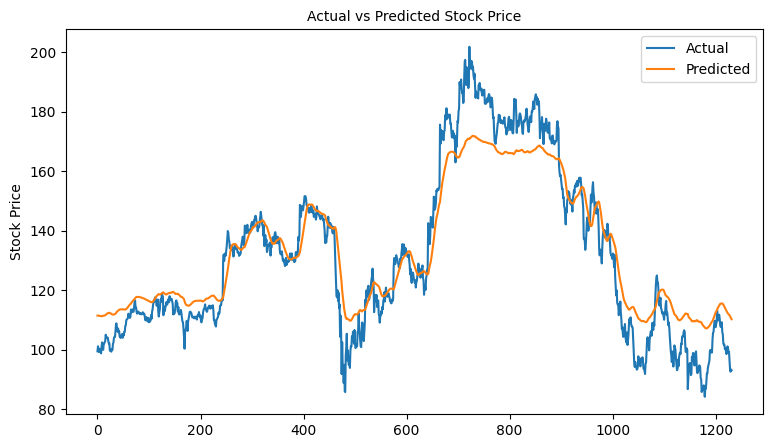

In [79]:
# Create the plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(acts, label='Actual')
ax.plot(preds, label='Predicted')

# Set the x-axis label and title
#ax.set_xlabel('Date', size=15)
ax.set_ylabel('Stock Price', size=10)
ax.set_title('Actual vs Predicted Stock Price', size=10)

# Display the plot
plt.legend()
plt.show()

# Forecast stock price

In [80]:
def forecast_stock_price(model, stock_data, seq_len, days):

  time_series_data = list(stock_data['Close'][-seq_len:]) 
  #print(time_series_data)
  forecast_data = np.array([np.nan] * len(stock_data))

  for i, step in enumerate(range(days)):

    time_series_data_array = np.array(time_series_data[-seq_len:]).reshape(-1, 1)

    model.cpu()
    model.eval()

    with torch.no_grad():
      forecast = torch.Tensor(time_series_data_array).unsqueeze(0)
      forecast = model(forecast)
      
    forecast = forecast.detach().numpy().reshape(-1).squeeze()
    forecast_it = sc.inverse_transform(forecast.reshape(-1,1))
    forecast_it = forecast_it[-1][0]  
    time_series_data.append(forecast_it)
    #print(time_series_data)

    forecast_data = np.append(forecast_data, forecast[-1])

  return forecast_data

In [81]:
forecast_days = 180
seq_len = 90

forecasts = forecast_stock_price(model, stock_data=stock_price_raw, seq_len=seq_len, days=forecast_days)
forecasts = sc.inverse_transform(forecasts.reshape(-1,1)).flatten().tolist()

# Plot forecast 

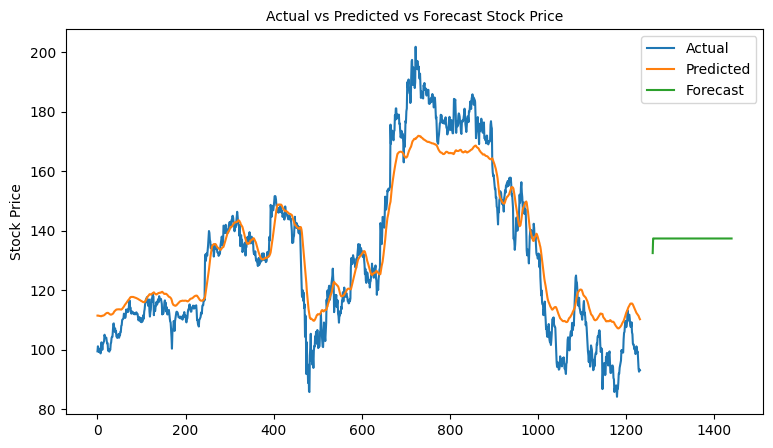

In [82]:
# Create the plot
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(acts, label='Actual')
ax.plot(preds, label='Predicted')
ax.plot(forecasts, label='Forecast')

# Set the x-axis label and title
ax.set_ylabel('Stock Price', size=10)
ax.set_title('Actual vs Predicted vs Forecast Stock Price', size=10)

# Display the plot
plt.legend()
plt.show()